### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
251,PSID67,0,42,7,0,0,1,1,10971.8900,5806.0160,9241.7020
65,NSW66,1,28,9,1,0,0,1,0.0000,0.0000,10694.2900
5,NSW6,1,22,9,1,0,0,1,0.0000,0.0000,4056.4940
470,PSID286,0,49,8,0,0,1,1,14684.7000,136.0645,14963.4600
430,PSID246,0,41,7,0,0,1,1,19573.0800,565.7419,0.0000
9,NSW10,1,33,12,0,0,1,0,0.0000,0.0000,12418.0700
244,PSID60,0,25,7,0,0,1,1,5597.6250,6099.6290,122.6513
455,PSID271,0,17,11,0,1,0,1,803.2994,248.8548,5173.5210
324,PSID140,0,19,9,1,0,0,1,1079.5560,2873.4680,14344.2900
32,NSW33,1,25,11,1,0,1,1,0.0000,0.0000,1574.4240


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

<AxesSubplot:xlabel='treat', ylabel='re78'>

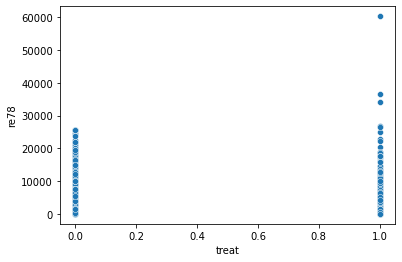

In [3]:
sns.scatterplot(x = 'treat', y = 're78', data = df)

<AxesSubplot:xlabel='re78', ylabel='Count'>

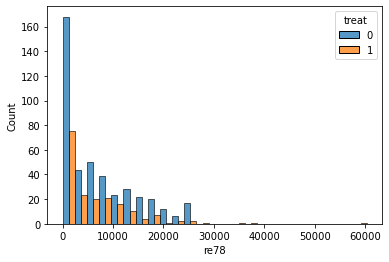

In [5]:
sns.histplot(x = 're78', data = df, hue = 'treat', multiple = 'dodge')

In [7]:
print(df.re78[df.treat == 0].mean())
print(df.re78[df.treat == 1].mean())

6984.169742307697
6349.143530270269


<AxesSubplot:xlabel='treat', ylabel='re78'>

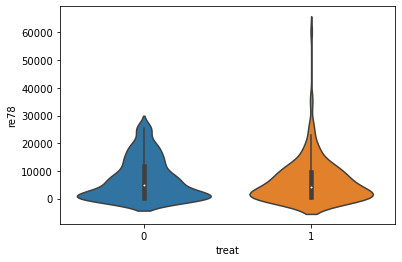

In [8]:
sns.violinplot(x = 'treat', y = 're78', data = df)

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [9]:
df.groupby(['treat']).mean()

,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,,,,,,,,,
0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
1,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530


<AxesSubplot:xlabel='age', ylabel='educ'>

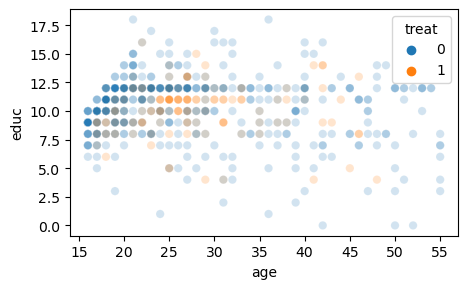

In [18]:
plt.figure(figsize=(5, 3), dpi=100)
sns.scatterplot(x='age', y='educ', data=df, hue='treat', alpha=0.2)

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [26]:
import statsmodels.formula.api as smf

# Predict propensity score = probability of receiving a treatment in the first place
# Can only use regressors which were available BEFORE treatment choice. Pre-treatment.
# Cannot use re78, it's post-treatment

mod = smf.logit(formula = '''treat ~ age + educ + black + 
                            hispan + married + nodegree + re74 + re75''', data = df)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Sat, 08 Jan 2022   Pseudo R-squ.:                  0.3508
Time:                        20:35:03   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.014      1.162      0.245      -0.011       0.042
educ           0.1613      0.065      2.477      0.013       0.034       0.289
black          3.0654      0.287     10.698      0.000       2.504       3.627
hispan         0.9836      0.426      2.311      0.021       0.149       1.818
married       -0.8321      0.290     -2.866      0.004      -1.401      -0.263
nodegree       0.7073      0.338      2.095      0.036       0.045       1.369
re74       -7.178e-05   2.87e-05     -2.497      0.013      -0.000   -1.54e-05
re75        5.345e-05   4.63e-05      1.153      0.249   -3.74e-05       0.000
==============================================================================
"""

In [28]:
# High R2 = model explains PROBABILITY! well enough.
# This means experiment is not random at all, as can predict the treatment group.

In [30]:
probs = res.predict(exog = df)
probs

0      0.638770
1      0.224634
2      0.678244
3      0.776324
4      0.701639
         ...   
609    0.123144
610    0.034560
611    0.183351
612    0.383032
613    0.089712
Length: 614, dtype: float64

In [33]:
# We want to take pairs with similar score
# This removes selection bias
# Similar score = similar people

df['PS'] = probs
df.sample(3)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,PS
435,PSID251,0,16,9,0,0,0,1,0.0000,485.1774,4112.513,0.091852
451,PSID267,0,21,14,0,0,0,0,107.7597,293.6129,7698.955,0.106113
95,NSW96,1,25,12,0,0,0,0,0.0000,0.0000,5587.503,0.083284


## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [34]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [35]:
# Separate the treatment and control groups
treatment_df = df[df['treat'] == 1]
control_df = df[df['treat'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['PS'],
                                    treatment_row['PS'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [38]:
df

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,PS
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.638770
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.224634
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.678244
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.776324
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.701639
...,...,...,...,...,...,...,...,...,...,...,...,...
609,PSID425,0,18,11,0,0,0,1,0.0,0.0,10150.5000,0.123144
610,PSID426,0,24,1,0,1,1,1,0.0,0.0,19464.6100,0.034560
611,PSID427,0,21,18,0,0,0,0,0.0,0.0,0.0000,0.183351
612,PSID428,0,32,5,1,0,1,1,0.0,0.0,187.6713,0.383032


In [36]:
matching

{(0, 404),
 (1, 594),
 (3, 526),
 (5, 510),
 (8, 529),
 (10, 452),
 (12, 557),
 (14, 295),
 (16, 453),
 (17, 474),
 (19, 199),
 (21, 366),
 (24, 372),
 (25, 588),
 (32, 369),
 (33, 253),
 (41, 459),
 (42, 519),
 (43, 435),
 (44, 558),
 (45, 511),
 (48, 525),
 (49, 294),
 (50, 539),
 (51, 284),
 (52, 573),
 (56, 555),
 (57, 604),
 (58, 364),
 (65, 585),
 (66, 611),
 (69, 318),
 (72, 449),
 (74, 596),
 (78, 302),
 (79, 383),
 (80, 412),
 (81, 375),
 (83, 565),
 (88, 322),
 (89, 348),
 (90, 386),
 (93, 582),
 (96, 437),
 (97, 590),
 (98, 363),
 (101, 583),
 (104, 515),
 (105, 357),
 (106, 556),
 (108, 340),
 (112, 260),
 (113, 342),
 (114, 411),
 (115, 574),
 (116, 414),
 (118, 551),
 (120, 607),
 (125, 190),
 (128, 513),
 (129, 550),
 (130, 535),
 (131, 423),
 (132, 542),
 (136, 293),
 (137, 571),
 (140, 518),
 (143, 343),
 (144, 279),
 (145, 537),
 (149, 422),
 (150, 415),
 (152, 278),
 (153, 469),
 (155, 492),
 (160, 268),
 (161, 273),
 (162, 455),
 (166, 575),
 (167, 311),
 (169, 418)

In [41]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
matched[0:5] #it's just the index of every element we matched. Others we've trashed
# Use iloc to use indices

[401, 466, 361, 155, 376]

In [46]:
df_b = df.iloc[matched]
df_b.groupby(['treat']).mean() #balanced

,age,educ,black,hispan,married,nodegree,re74,re75,re78,PS
treat,,,,,,,,,,
0,25.302703,10.605405,0.470270,0.216216,0.210811,0.637838,2342.107564,1614.745125,5454.77605,0.362891
1,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.14353,0.577436


In [45]:
df.groupby(['treat']).mean() #unbalanced

,age,educ,black,hispan,married,nodegree,re74,re75,re78,PS
treat,,,,,,,,,,
0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742,0.182225
1,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.577436


## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [7]:
treatment_df = lalonde_data[lalonde_data['treat'] == 1]
control_df = lalonde_data[lalonde_data['treat'] == 0]


G = nx.Graph()

for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Adds an edge only if the individuals have the same race
        if (control_row['black'] == treatment_row['black'])\
            and (control_row['hispan'] == treatment_row['hispan']):
            similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])

            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

matching_race = nx.max_weight_matching(G)
matched_race = [i[0] for i in list(matching_race)] + [i[1] for i in list(matching_race)]
df_r = df.iloc[matched_race]

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [49]:
f = '''re78 ~ treat + age + educ + black + 
                            hispan + married + nodegree + re74 + re75'''

In [50]:
# ols1
smf.ols(formula = f, data = df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     11.64
Date:                Sat, 08 Jan 2022   Prob (F-statistic):           5.99e-17
Time:                        21:21:22   Log-Likelihood:                -6297.8
No. Observations:                 614   AIC:                         1.262e+04
Df Residuals:                     604   BIC:                         1.266e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.5145   2436.746      0.027      0.978   -4719.009    4852.038
treat       1548.2438    781.279      1.982      0.048      13.890    3082.598
age           12.9776     32.489      0.399      0.690     -50.827      76.783
educ         403.9412    158.906      2.542      0.011      91.865     716.017
black      -1240.6441    768.764     -1.614      0.107   -2750.420     269.132
hispan       498.8969    941.943      0.530      0.597   -1350.983    2348.777
married      406.6208    695.472      0.585      0.559    -959.217    1772.458
nodegree     259.8174    847.442      0.307      0.759   -1404.474    1924.108
re74           0.2964      0.058      5.086      0.000       0.182       0.411
re75           0.2315      0.105      2.213      0.027       0.026       0.437
==============================================================================
Omnibus:                      216.123   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1182.664
Skew:                           1.467   Prob(JB):                    1.54e-257
Kurtosis:                       9.134   Cond. No.                     7.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
# ols2
smf.ols(formula = f, data = df_b).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.054
Date:                Sat, 08 Jan 2022   Prob (F-statistic):             0.0329
Time:                        21:21:47   Log-Likelihood:                -3792.6
No. Observations:                 370   AIC:                             7605.
Df Residuals:                     360   BIC:                             7644.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2112.2106   3511.770     -0.601      0.548   -9018.372    4793.951
treat       1344.9356    789.780      1.703      0.089    -208.227    2898.098
age            7.8035     42.915      0.182      0.856     -76.592      92.199
educ         602.2032    224.070      2.688      0.008     161.553    1042.854
black       -469.4337   1009.928     -0.465      0.642   -2455.534    1516.667
hispan      1064.0449   1300.198      0.818      0.414   -1492.892    3620.981
married     -158.2545    986.307     -0.160      0.873   -2097.903    1781.394
nodegree     923.2840   1109.915      0.832      0.406   -1259.447    3106.015
re74           0.0264      0.103      0.256      0.798      -0.176       0.229
re75           0.2207      0.160      1.383      0.168      -0.093       0.534
==============================================================================
Omnibus:                      205.711   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1892.330
Skew:                           2.178   Prob(JB):                         0.00
Kurtosis:                      13.187   Cond. No.                     5.76e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""